# Inverting gradient attack

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam, AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.functional import total_variation
import torchinfo
from image_classification.utils import trange

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## ResNet-18

In [3]:
from image_classification.models import ResNet18
from image_classification.datasets import cifar10_train_test, cifar100_train_test
from image_classification.nn import train_loop, train_val_loop, test_epoch

Using cuda device


In [4]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by theses datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [5]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [6]:
lr = 1e-3
weight_decay = 5e-4
# For learning rate scheduling
max_lr = 0.1

epochs = 6
steps_per_epoch = N // batch_size

lr_sched_params = dict(max_lr=max_lr, epochs=epochs, steps_per_epoch=steps_per_epoch)

criterion = CrossEntropyLoss()

top_k = {10: 1, 100: 5}[num_classes]

metric = MulticlassAccuracy(num_classes=num_classes, top_k=top_k)

### Optimizer (TODO: compare SGD & Adam)

In [7]:
def make_optimizer(model: nn.Module, opt_name='adamw', lr=lr, weight_decay=weight_decay, **kwargs) -> Optimizer:
    cls = {'sgd': SGD, 'adam': Adam, 'adamw': AdamW}[opt_name]
    return cls(model.parameters(), lr=lr, weight_decay=weight_decay, **kwargs)

## Inverting gradient attack

In [8]:
# TODO: gradients per parameter instead?
def model_gradients(model: nn.Module) -> Tensor:
    """
    Returns the model gradients without detaching them.
    """
    grads = [
        param.grad.flatten()
        for param in model.parameters()
    ]
    return torch.cat(grads)

def average_model_gradient(model: nn.Module, batch_size: int) -> Tensor:
    """
    Returns the model gradient averaged over the batch size.

    Assumes the gradients have already been computed with loss backpropagation.
    """
    return model_gradients(model).detach().clone() / batch_size

In [9]:
max_data_variation = training_data.max_data_variation()

In [10]:
from enum import Enum

class GradientAttack(Enum):
    """
    A type of gradient attack.
    """
    
    ASCENT = 0              # Gradient Ascent (Blanchard et al., 2017)
    ORTHOGONAL = 1          # Orthogonal Gradient
    LITTLE_IS_ENOUGH = 2    # Little is Enough (Shejwalkar & Houmansadr, 2021)

In [11]:
def inverting_gradient_attack(
        model: nn.Module, criterion: _Loss,
        avg_clean_gradient: Tensor, x_base: Tensor, y_base: Tensor,
        steps = 10,
        tv_coef = 1.0,
        method = GradientAttack.ASCENT,
    ) -> Tensor:
    """
    Create a poisoned data point with an inverting gradient attack.
    """

    model.eval()
    model.requires_grad_()
    model.zero_grad()
    avg_clean_gradient.requires_grad_(False)
    
    # TODO: find appropriate lr scheduling step
    opt = Adam([x_base], lr=0.5)

    for step in range(steps):
        # `criterion` gradients must only be computed for `model`
        #x_base.requires_grad_(False)
        x_base.requires_grad_(True)

        loss = criterion(model(x_base.unsqueeze(0)), y_base.unsqueeze(0))
        loss.backward(create_graph=True) # Allows 2nd-order differentiation

        # TODO: gradients per parameter instead
        g_p = model_gradients(model)

        match method:
            case GradientAttack.ASCENT:
                cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                # dot product increases the gradient size but makes unalignment easier
                #loss_adv = g_p.dot(avg_clean_gradient)      
                loss_adv = cos_sim
            
            case GradientAttack.ORTHOGONAL:
                cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                # dot product increases the gradient size but makes unalignment easier
                #loss_adv = g_p.dot(avg_clean_gradient)      
                loss_adv = cos_sim.dot(cos_sim)

            case GradientAttack.LITTLE_IS_ENOUGH:
                # See Algorithm 3 in https://arxiv.org/pdf/1902.06156
                raise NotImplementedError

        if tv_coef:
            tv = total_variation(x_base.unsqueeze(0))
            normalization = x_base.numel() * 4 * max_data_variation ** 2
            loss_adv += tv_coef * tv / normalization

        #print(f"Inverting gradient step {step}: loss = {loss.item()}, cos_sim = {cos_sim.item()}")
        
        # TODO: torch.autograd??? test on a simpler model for debugging
        #x_base.requires_grad_(True)
        opt.zero_grad()

        loss_adv.backward()
        opt.step()
        opt.zero_grad()
        model.zero_grad()

        x_base.requires_grad_(False)
        training_data.clip_to_data_range(x_base, inplace=True)
    
    model.train()
    return x_base


In [12]:
# https://github.com/pytorch/pytorch/issues/23900
def cycle(iterable: DataLoader):
    """
    Cycle through the elements of a dataloader infinitely.
    """
    iterator = iter(iterable)
    while True:
        try:
            yield next(iterator)
        except StopIteration:
            iterator = iter(iterable)

class GradientEstimator:
    """A class for average model gradient estimation."""
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        """
        Estimate the average gradient on a clean-distributed dataset.
        """
        raise NotImplementedError

class OmniscientGradientEstimator(GradientEstimator):
    """
    Estimates the average gradient assuming it has already been computed
    on a mini-batch with loss backpropagation.

    # Example
    ```python
    grad_estim = OmniscientGradientEstimator(batch_size)
    loss = criterion(model(X), y)
    loss.backward()
    avg_clean_gradient = grad_estim.average_clean_gradient(model, criterion)
    ```
    """
    def __init__(self, batch_size: int):
        super().__init__()
        self.batch_size = batch_size
    
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        return average_model_gradient(model, self.batch_size)
    

class ShadowGradientEstimator(GradientEstimator):
    """
    Estimate the average clean gradient with an auxiliary dataset
    that is similarly distributed to the training dataset.
    """
    def __init__(self, aux_loader: DataLoader):
        self.aux_loader = cycle(aux_loader)
    
    def average_clean_gradient(self, model: nn.Module, criterion: _Loss) -> Tensor:
        # TODO: estimate on next mini-batch of aux_loader
        raise NotImplementedError

### Visualization

In [13]:
def display_input_image(input: Tensor, label: Tensor, title='', cmap=None):
    """
    Displays an an input image to a neural network.

    `input`: a 3D tensor
    `cmap`: grayscale by default.
    """
    decoders = {
        10: training_data.decode_cifar10_image,
        100: training_data.decode_cifar100_image,
    }
    image = decoders[len(training_data.classes)](input)
    class_ = training_data.decode_target(label)

    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, interpolation='nearest')
    plt.title(class_)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

In [14]:
def test_attack(
        model: nn.Module, criterion: _Loss,
        train_loader: DataLoader,
        poison_opt_steps: int = 10,
    ):
    model.eval()
    model.zero_grad()

    grad_estim = OmniscientGradientEstimator(train_loader.batch_size)

    X, y = next(iter(train_loader))
    X, y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits, y)
    loss.backward()

    #y_p = y[0].detach().clone()
    #X_p = X[0].detach().clone()
    X_p, y_p = training_data.random_sample_noise()
    y_p = y_p.to(device)

    avg_clean_gradient = grad_estim.average_clean_gradient(model, criterion)
    X_p = inverting_gradient_attack(
        deepcopy(model),
        criterion,
        avg_clean_gradient,
        X_p, y_p, steps=poison_opt_steps
    )

    model.zero_grad()

    #display_input_image(X[0], y[0], title="Clean sample")
    display_input_image(
        X_p, y_p,
        title=f"Poisoned sample (batch_size={len(X)}, {poison_opt_steps=})",
    )

    return X, y, X_p, y_p

### Poisoning

In [15]:
from image_classification.datasets import UpdatableDataset
from image_classification.nn import MetricLogger

def train_epoch_with_poisons(
        model: nn.Module,
        dataloader: DataLoader,
        criterion: _Loss,
        optimizer: Optimizer,
        keep_pbars=True,
        poison_opt_steps=10,
        alpha_poison=0.2,
    ) -> tuple[UpdatableDataset, MetricLogger]:
    #optimizer.zero_grad()
    model.train()

    logger = MetricLogger(
        metric,
        device=device,
        desc='Train loop', total=len(dataloader.dataset), keep_pbars=keep_pbars,
    )
    poison_set = UpdatableDataset()
    grad_estim = OmniscientGradientEstimator(dataloader.batch_size)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()

        # --- poisoning attack
        
        avg_clean_gradient = grad_estim.average_clean_gradient(model, criterion)

        #b_size = dataloader.batch_size
        #i = np.random.randint(0, b_size)
        #y_p = y[i].detach().clone()
        #X_p = X[i].detach().clone()

        X_p, y_p = training_data.random_sample_noise()
        y_p = y_p.to(device)

        X_p = inverting_gradient_attack(
            deepcopy(model),
            criterion,
            avg_clean_gradient,
            X_p, y_p, steps=poison_opt_steps
        )
        poison_set.append(X_p, y_p)

        logits_p = model(X_p.unsqueeze(0))
        loss_p = alpha_poison * criterion(logits_p, y_p.unsqueeze(0))

        # This adds to `loss` model gradients due to gradient accumulation
        loss_p.backward()
        
        # ---

        optimizer.step()
        optimizer.zero_grad()

        # FIXME: does not include X_p, y_p, logits_p, loss_p
        # TODO: log loss on poisons
        # TODO: display some poisons
        logger.compute_metrics(X, y, logits, loss.item())
    
    logger.finish()
    return poison_set, logger

In [16]:
def train_loop_with_poisons(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: _Loss,
        optimizer: Optimizer,
        epochs: int,
        poison_opt_steps=5,
        alpha_poison=0.05,
        metric=metric,
    ) -> TensorDataset:
    poison_set = UpdatableDataset()
    for epoch in trange(epochs, desc='Train epochs', unit='epoch', leave=True):
        poison_set_epoch, _ = train_epoch_with_poisons(
            model, train_loader,
            criterion, optimizer,
            poison_opt_steps=poison_opt_steps, alpha_poison=alpha_poison
        )
        poison_set.extend(poison_set_epoch)
        test_epoch(model, val_loader, criterion, keep_pbars=True, metric=metric)
    return poison_set.to_tensor_dataset()

In [33]:
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='adam', lr=lr)
# Pretrain the model to make it learn the features
train_val_loop(
    net, train_loader, val_loader,
    criterion, opt,
    epochs=1,
)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:22<00:00, 1800.48it/s, avg_loss=1.42]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5584.33it/s, avg_loss=1.34]


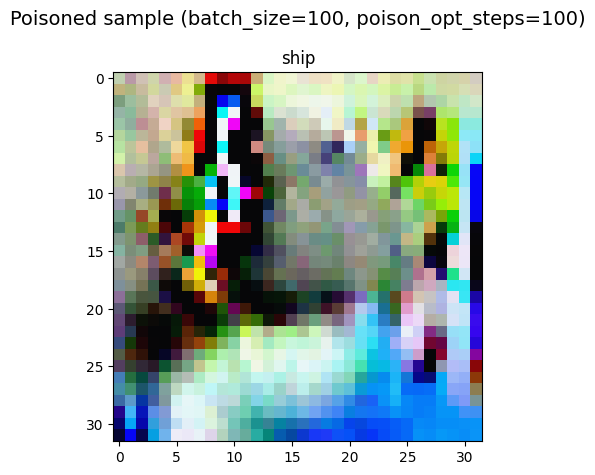

In [42]:
# This is a form of data reconstruction attack
test_attack(net, criterion, train_loader, poison_opt_steps=100);

In [19]:
# SGD is more vulnerable to gradient attacks
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    poison_opt_steps=5, alpha_poison=0.2,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:11<00:00, 560.38it/s, MulticlassAccuracy=0.318, avg_loss=1.97]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5562.53it/s, MulticlassAccuracy=0.283, avg_loss=1.94]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:12<00:00, 551.05it/s, MulticlassAccuracy=0.445, avg_loss=1.66]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5462.55it/s, MulticlassAccuracy=0.3, avg_loss=2.07]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:13<00:00, 544.31it/s, MulticlassAccuracy=0.548, avg_loss=1.52]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5404.73it/s, MulticlassAccuracy=0.269, avg_loss=1.84]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:14<00:00, 538.68it/s, MulticlassAccuracy=0.527, avg_loss=1.41]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5357.12it/s, MulticlassAccuracy=0.305, avg_loss=1.8]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 524.53it/s, MulticlassAccuracy=0.577, avg_loss=1.32]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5282.03it/s, MulticlassAccuracy=0.327, avg_loss=1.81]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.49it/s, MulticlassAccuracy=0.661, avg_loss=1.23]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5319.39it/s, MulticlassAccuracy=0.293, avg_loss=1.85]


batch_size = 100, alpha = 0.2, poison_opt_steps = 2, ResNet18, SGD(weight_decay=0.0), epochs = 6:

accuracy : 58 -> 34

TODO: test with more poison steps or different lr for poison optimizer

#### Lower poisoning rate

In [20]:
net = ResNet18(num_classes=num_classes).to(device)

In [21]:
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    poison_opt_steps=5, alpha_poison=0.05,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `total_variation` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `total_variation` from `torchmetrics.image` instead.
  _future_warning(


Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 513.43it/s, MulticlassAccuracy=0.385, avg_loss=1.97]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5242.91it/s, MulticlassAccuracy=0.206, avg_loss=2.02]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 524.14it/s, MulticlassAccuracy=0.514, avg_loss=1.65]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5338.03it/s, MulticlassAccuracy=0.276, avg_loss=2.02]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 511.75it/s, MulticlassAccuracy=0.527, avg_loss=1.51]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5338.56it/s, MulticlassAccuracy=0.298, avg_loss=2.05]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 527.60it/s, MulticlassAccuracy=0.565, avg_loss=1.4]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5326.21it/s, MulticlassAccuracy=0.331, avg_loss=1.83]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:15<00:00, 527.11it/s, MulticlassAccuracy=0.579, avg_loss=1.3]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5306.51it/s, MulticlassAccuracy=0.3, avg_loss=1.95]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:16<00:00, 525.30it/s, MulticlassAccuracy=0.622, avg_loss=1.21]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5289.17it/s, MulticlassAccuracy=0.315, avg_loss=2.03]


Result : accuracy drops to 30 %

#### Using Adam optimizer for training

In [22]:
net = ResNet18(num_classes=num_classes).to(device)

In [23]:
# Adam regularizes the parameters so it is more robust to gradient attacks
opt = make_optimizer(net, opt_name='adam', lr=lr)
train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    poison_opt_steps=5, alpha_poison=0.2,
)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:21<00:00, 493.71it/s, MulticlassAccuracy=0.686, avg_loss=1.46]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5302.29it/s, MulticlassAccuracy=0.475, avg_loss=1.75]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 512.15it/s, MulticlassAccuracy=0.683, avg_loss=1.04]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5242.08it/s, MulticlassAccuracy=0.619, avg_loss=1.39]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 514.01it/s, MulticlassAccuracy=0.776, avg_loss=0.857]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5259.90it/s, MulticlassAccuracy=0.439, avg_loss=1.94]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 509.10it/s, MulticlassAccuracy=0.803, avg_loss=0.721]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5185.23it/s, MulticlassAccuracy=0.438, avg_loss=1.89]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 508.39it/s, MulticlassAccuracy=0.8, avg_loss=0.626]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5190.02it/s, MulticlassAccuracy=0.572, avg_loss=1.42]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 509.13it/s, MulticlassAccuracy=0.818, avg_loss=0.557]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5192.24it/s, MulticlassAccuracy=0.556, avg_loss=1.62]


## Machine unlearning

In [24]:
from image_classification.unlearning import gradient_descent, neg_grad_plus, unlearning_last_layers

TODO: test this against SGD first...

Refactor and create objects:
- GradientInverter
- PoisonedTrainer: store generated poisons

In [25]:
net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(net, opt_name='sgd', lr=lr)
forget_set = train_loop_with_poisons(
    net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    poison_opt_steps=5, alpha_poison=0.2,
)
forget_loader = DataLoader(forget_set, batch_size)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 511.78it/s, MulticlassAccuracy=0.393, avg_loss=1.97]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5156.76it/s, MulticlassAccuracy=0.245, avg_loss=2.06]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:17<00:00, 513.07it/s, MulticlassAccuracy=0.525, avg_loss=1.66]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5152.47it/s, MulticlassAccuracy=0.282, avg_loss=2.08]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 511.65it/s, MulticlassAccuracy=0.539, avg_loss=1.52]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5180.91it/s, MulticlassAccuracy=0.325, avg_loss=1.9]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:18<00:00, 511.89it/s, MulticlassAccuracy=0.532, avg_loss=1.41]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5176.47it/s, MulticlassAccuracy=0.324, avg_loss=1.89]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:19<00:00, 501.26it/s, MulticlassAccuracy=0.577, avg_loss=1.32]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4996.24it/s, MulticlassAccuracy=0.325, avg_loss=1.88]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:21<00:00, 488.35it/s, MulticlassAccuracy=0.57, avg_loss=1.23]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4984.27it/s, MulticlassAccuracy=0.327, avg_loss=1.97]


In [26]:
class Unlearning(Enum):
    GRADIENT_DESCENT = 0
    GRADIENT_ASCENT = 1
    NOISY_GRADIENT_DESCENT = 2
    NEG_GRAD_PLUS = 3
    CFK = 4
    EUK = 5
    SCRUB = 6

In [27]:
def unlearn(
        net: nn.Module,
        train_loader: DataLoader,
        forget_loader: DataLoader,
        criterion: _Loss,
        method: Unlearning,
    ):
    unlearner = deepcopy(net)
    
    match method:
        case Unlearning.GRADIENT_DESCENT:
            opt = make_optimizer(unlearner, opt_name='sgd', lr=lr)
            gradient_descent(
                unlearner, train_loader, val_loader,
                criterion, opt, epochs=1, keep_pbars=False
            )
        
        case Unlearning.NEG_GRAD_PLUS:
            opt = make_optimizer(unlearner, opt_name='sgd', lr=lr)
            for epoch in trange(10, desc='NegGrad+ epochs', unit='epoch', leave=True):
                neg_grad_plus(
                    unlearner, train_loader, forget_loader,
                    criterion, opt, keep_pbars=False
                )
    
        case Unlearning.EUK:
            opt = make_optimizer(unlearner, opt_name='adam', lr=lr)
            with unlearning_last_layers(unlearner, 6, 'euk'):
                train_loop(unlearner, train_loader, criterion, opt, epochs=1)
    
    return unlearner

#### No poisoning

In [28]:
clean_net = ResNet18(num_classes=num_classes).to(device)
opt = make_optimizer(clean_net, opt_name='sgd', lr=lr)
train_val_loop(
    clean_net, train_loader, val_loader,
    criterion, opt,
    epochs=epochs,
    metric=metric,
);
test_epoch(clean_net, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1679.78it/s, MulticlassAccuracy=0.399, avg_loss=1.97]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5028.12it/s, MulticlassAccuracy=0.329, avg_loss=1.75]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1671.01it/s, MulticlassAccuracy=0.501, avg_loss=1.64]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1681.65it/s, MulticlassAccuracy=0.554, avg_loss=1.49]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5030.82it/s, MulticlassAccuracy=0.391, avg_loss=1.47]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1682.72it/s, MulticlassAccuracy=0.624, avg_loss=1.38]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1674.42it/s, MulticlassAccuracy=0.631, avg_loss=1.29]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4929.21it/s, MulticlassAccuracy=0.469, avg_loss=1.34]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:23<00:00, 1678.24it/s, MulticlassAccuracy=0.639, avg_loss=1.21]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4952.11it/s, MulticlassAccuracy=0.492, avg_loss=1.29]


#### No unlearning

In [29]:
test_epoch(net, val_loader, criterion, keep_pbars=True, metric=metric);

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5035.53it/s, MulticlassAccuracy=0.327, avg_loss=1.97]


#### Gradient descent

In [30]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.GRADIENT_DESCENT)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4927.82it/s, MulticlassAccuracy=0.514, avg_loss=1.25]


#### NegGrad+

In [31]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.NEG_GRAD_PLUS)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

NegGrad+ epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/2400 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4957.74it/s, MulticlassAccuracy=0.282, avg_loss=1.94]


#### EUk ($k = 6$)

In [32]:
unlearner = unlearn(net, train_loader, forget_loader, criterion, Unlearning.EUK)
test_epoch(unlearner, val_loader, criterion, keep_pbars=True, metric=metric);

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:09<00:00, 4241.48it/s, avg_loss=1.21]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5001.93it/s, MulticlassAccuracy=0.522, avg_loss=1.28]


TODO: test `unlearning.model_layers()` correctness and check EUk results again on other notebooks

### Remaining tasks

- Refactoring
- Change reconstruction attack by starting from a random pattern
- _Little is Enough_ attack
- Mean gradient estimation with auxiliary dataset
- Testing against unlearning
- Testing with different configs (optimizer, number of epochs, batch size, models)